# Deep Q-Network (DQN)
---
In this notebook, I implemented several DQN agents with OpenAI Gym's LunarLander-v2 environment.

The work is based on a project by the Udacity Deep Reinforcement Learning Nanodegree: https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

This Notebook is part of the GitHub repository: https://github.com/dralmabeck and based on https://github.com/udacity/deep-reinforcement-learning

### 1. Import the Necessary Packages

In [1]:
import gym
import time
import pickle
import math
import datetime
import random
import numpy as np
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


### Watch an untrained Agent

In [3]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

The following sections show my code and results from my work on this project.

I have implemented two different neural network architectures:
- Standard neural network with three fully connected layers with sizes of: 8 (states) -> 128 (hidden) -> 128 (hidden) -> 4 (actions)
- Duelling neural network (https://arxiv.org/abs/1511.06581) with two shared fully connected layers of size: 8 (states) -> 128 (hidden) -> 128 (hidden) and two seperated fully connected layers with one of sizes 128 (hidden) -> 64 (hidden) -> 1 (value branch) and one with sizes 128 (hidden) -> 64 (hidden) -> 4 (advantage branch)

Both neural network architectures implement:
- Linear fully connected layers: https://pytorch.org/docs/master/generated/torch.nn.Linear.html
- Exponential linear unit activation function: https://pytorch.org/docs/stable/nn.html#torch.nn.ELU
- Dropout between fully connected layersfor regularization: https://pytorch.org/docs/master/generated/torch.nn.Dropout.html

I have implemented four different agents interacting with the environment:
- SingleAgent:

 - Standard implementation of Agent using:
 - Standard neural QNetwork with three fully connected layers, exponential linear unit and dropout regularization
 - Standard Q-learning algorithm
 - Standard epsilon greedy policy
 - Standard experience replay with random sampling
 - Standard Mean-squared-error loss function
 - Adam optimizer: https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam
 

- DoubleAgent:

 - Same as SingleAgent with two changes:
 - Double Q-Learning algorithm instead of single Q-Learning algorithm: https://arxiv.org/abs/1509.06461
 - Duelling neural DuelQNetwork instead of standard QNetwork

- Triple Agent:

 - Same as SingleAgent with two changes:
 - Prioritized experience replay: https://arxiv.org/abs/1511.05952
 - Weighted mean-squared-error loss function

- QuadrupleAgent:

 - Same as TripleAgent with one change:
 - Duelling neural DuelQNetwork instead of standard QNetwork

Note that the QuadrupleAgent features many of the improvements used in the Rainbow implementation (https://arxiv.org/abs/1710.02298), which is a state-of-the-art list of improvements and combined implementation for Deep Reinforcement learning.

### Setting of variables for the neural network, training algorithms and unity environments

In [4]:
BUFFER_SIZE = int(1e5)     # replay buffer size
BATCH_SIZE = 64            # minibatch size
GAMMA = 0.99               # discount factor
TAU = 0.001                # for soft update of target parameters
LR = 0.0005                # learning rate 
UPDATE_EVERY = 4           # how often to update the network

FC_SIZE = 48               # number of neurons in layer of neural network
P_DROPOUT = 0.0            # dropout probability for neurons and network regularization

ACTION_SIZE = 4            # number of actions
STATE_SIZE = 8             # number of states

N_EPISODES = 2000          # number of maximum episodes for training
MAX_T = 1000               # maximum time agent is in the environment in each episode
EPS_START = 1.0            # Initial Epsilon for Exploration - Exploitation
EPS_END = 0.01             # minimum value of epsilon
EPS_DECAY = 0.995          # linear decay of epsilon each timestep

ALPHA_INITIAL = 0.6        # exponent of priorization https://arxiv.org/pdf/1511.05952.pdf
BETA_INITIAL = 0.4         # exponent of importance sampling weights https://arxiv.org/pdf/1511.05952.pdf

ENV_SOLVED = 200.0 + 15.0        # average score of agent to consider environment solved

RANDOM_SEED = 2            # seed integer for random number generator

### Check if training on GPU is possible, else use CPU

In [5]:
# If GPU is available use for training otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device = "cpu"

if device == "cpu":
    print("Available: CPU only")
else:
    print("Available: GPU cuda")

Available: CPU only


### Implementation of the standard neural network architecture
Standard neural network with three fully connected layers with sizes of: 8 (states) -> 128 (hidden) -> 128 (hidden) -> 4 (actions)
- Linear fully connected layers: https://pytorch.org/docs/master/generated/torch.nn.Linear.html
- Exponential linear unit activation function: https://pytorch.org/docs/stable/nn.html#torch.nn.ELU
- Dropout between fully connected layersfor regularization: https://pytorch.org/docs/master/generated/torch.nn.Dropout.html

In [6]:
class QNetwork(nn.Module):

    def __init__(self):

        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
    
        self.fc1 = nn.Linear(STATE_SIZE, 2*FC_SIZE) # Size 8 -> 128
        self.fc2 = nn.Linear(2*FC_SIZE, 2*FC_SIZE) # Size 128 -> 128
        self.fc3 = nn.Linear(2*FC_SIZE, ACTION_SIZE) # Size 128 -> 4
        
        self.dropout = nn.Dropout(P_DROPOUT)

    def forward(self, state):
        
        x = F.elu(self.fc1(state)) # Exponential linear unit
        x = self.dropout(x) # Dropout for regularization
        
        x = F.elu(self.fc2(x))
        x = self.dropout(x)
        
        action = self.fc3(x)
        
        return action # Yield action for agent

### Implementation of the duelling neural network architecture
Duelling neural network (https://arxiv.org/abs/1511.06581)with two shared fully connected layers of size: 8 (states) -> 128 (hidden) -> 128 (hidden) and two seperated fully connected layers with one of sizes 128 (hidden) -> 64 (hidden) -> 1 (value branch) and one with sizes 128 (hidden) -> 64 (hidden) -> 4 (advantage branch)
- Linear fully connected layers: https://pytorch.org/docs/master/generated/torch.nn.Linear.html
- Exponential linear unit activation function: https://pytorch.org/docs/stable/nn.html#torch.nn.ELU
- Dropout between fully connected layersfor regularization: https://pytorch.org/docs/master/generated/torch.nn.Dropout.html
- Combination of value and advantage branches according to original paper implementation: https://arxiv.org/abs/1511.06581

In [7]:
class DuelQNetwork(QNetwork):

    def __init__(self):

        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
    
        self.fc1 = nn.Linear(STATE_SIZE, 2*FC_SIZE) # Size 8 -> 128
        self.fc2 = nn.Linear(2*FC_SIZE, 2*FC_SIZE) # Size 128 -> 128
        
        self.val_1 = nn.Linear(2*FC_SIZE, FC_SIZE) # Size 128 -> 64
        self.val_2 = nn.Linear(FC_SIZE, 1) # Size 64 -> 1
        
        self.adv_1 = nn.Linear(2*FC_SIZE, FC_SIZE) # Size 128 -> 64
        self.adv_2 = nn.Linear(FC_SIZE, ACTION_SIZE) # Size 64 -> 4
        
        self.dropout = nn.Dropout(P_DROPOUT)
        
    def forward(self, state):
        
        x = F.elu(self.fc1(state)) # Exponential linear unit
        x = self.dropout(x) # Dropout for regularization
        
        x = F.elu(self.fc2(x))
        x = self.dropout(x)
        
        # Value branch
        val = F.elu(self.val_1(x))
        val = self.val_2(val).expand(state.size(0), ACTION_SIZE)
        
        # Advantage branch
        adv = F.elu(self.adv_1(x))
        adv = self.adv_2(adv)
        
        # Q(s,a) = V(s) + A(s,a) - mean(A(s,a))
        action = val + adv - adv.mean(1).unsqueeze(1).expand(state.size(0), ACTION_SIZE)
        
        return action # Yield action for agent

### Implementation of experience replay buffer
Implementation follows the standard replay buffer implementation as described in the Udacity course videos regarding the DQN algorithm and the Lunar Lander example.

In [8]:
class ReplayBuffer:

    def __init__(self):

        self.memory = deque(maxlen = BUFFER_SIZE)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(RANDOM_SEED)
    
    # Add an experience to the memory
    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # Randomly sample experiences from the memory
    def sample(self):

        # Randomly draw a sample of size BATCH_SIZE
        experiences = random.sample(self.memory, k=BATCH_SIZE)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    # Calculate length of memory
    def __len__(self):

        return len(self.memory)

### Implementation of prioritized experience replay buffer

This implementation follows the Paper of https://arxiv.org/abs/1511.05952 and was inspired by https://github.com/ucaiado/banana-rl.

In [9]:
class PriorityReplayBuffer(ReplayBuffer):

    def __init__(self):

        super(ReplayBuffer, self).__init__()
        
        self.memory = deque(maxlen = BUFFER_SIZE)  
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(RANDOM_SEED)
        
        self.priority = deque(maxlen = BUFFER_SIZE)
        self.cum_priority = 0.0 # Initialize cumulative priorities with 0.0
        self.eps = 1e-6
        self.indices = []

    # Add an experience to the memory
    # Update the total sum of priorities
    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

        if len(self.priority) >= BUFFER_SIZE:
            self.cum_priority -= self.priority[0]

        self.priority.append(1.0)
        self.cum_priority += self.priority[-1]

    def sample(self):

        N = len(self.memory)
        na_probs = None
        
        # Get fraction of priorities to cumulative priority
        if self.cum_priority:
            na_probs = np.array(self.priority) / self.cum_priority
        
        # Randomly draw a sample of size BATCH_SIZE but with account to priorities
        l_index = np.random.choice(N, size=min(N, BATCH_SIZE),p=na_probs)
        self.indices = l_index

        # Sample from indices
        experiences = [self.memory[ii] for ii in l_index]

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    # Helper function for computing weights
    def calc_w(self, f_prio, beta, max_w, N):

        # Calculate weight
        f_w = (N * f_prio / self.cum_priority)
        
        # Bias correction
        result = (f_w ** (-beta)) / max_w
        return result

    # Calculate the weights of for each memory according to beta
    def calculate_weights(self, inp_beta):

        N = len(self.memory)
        
        # Maximum weight including bias correction
        max_w = (N * min(self.priority) / self.cum_priority) ** (-inp_beta)

        # Compute weight with helper function
        w = [self.calc_w(self.priority[ii], inp_beta, max_w, N) for ii in self.indices]
        
        result = torch.tensor(w, device = device, dtype = torch.float).reshape(-1, 1)
        return result

    # Update priorities
    def update_priority(self, td_err):

        for i, f_tderr in zip(self.indices, td_err):
            f_tderr = float(f_tderr)
            self.cum_priority -= self.priority[i]
            self.priority[i] = ((abs(f_tderr) + self.eps) ** ALPHA_INITIAL)
            self.cum_priority += self.priority[i]
        self.max_priority = max(self.priority)
        self.indices = []

    # Calculate length of memory
    def __len__(self):

        return len(self.memory)

### Implementation of the Single Agent:
Implementation follows the standard agent implementation as described in the Udacity course videos regarding the DQN algorithm and the Lunar Lander example.

Standard implementation of Agent using:
- Standard neural QNetwork with three fully connected layers, exponential linear unit and dropout regularization
- Standard Q-learning algorithm
- Standard epsilon greedy policy
- Standard experience replay with random sampling
- Standard Mean-squared-error loss function
- Adam optimizer: https://pytorch.org/docs/stable/_modules/torch/optim/adam.html#Adam

In [10]:
class SingleAgent():

    def __init__(self):
        
        self.state_size = STATE_SIZE
        self.action_size = ACTION_SIZE
        self.seed = random.seed(RANDOM_SEED)

        self.qnetwork_local = QNetwork().to(device) # Use standard network
        self.qnetwork_target = QNetwork().to(device) # Use standard network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)  #Initialize Optimizer with new network

        self.memory = ReplayBuffer() # Use standard experience replay
        self.t_step = 0

    # Perform step
    def step(self, state, action, reward, next_state, done):
        
        # Add to memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Propagate time
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # Learn from experiences
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)

    # Choose action for agent according to given policy
    def act(self, state, eps=0.):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # epsilon greedy policy for exploration and exploitation
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    # Learn from experiences
    def learn(self, experiences):
        
        states, actions, rewards, next_states, dones = experiences

        # Implement standardQ-learning
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # Calculate target Q
        Q_targets = rewards + (GAMMA * Q_targets_next * (1.0 - dones))

        # Get expected Q
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Standard mean-squared-error loss function
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Reset gradients
        self.optimizer.zero_grad()
        # perform backpropagation
        loss.backward()
        # Optimize weights
        self.optimizer.step()

        # Update networks
        self.soft_update(self.qnetwork_local, self.qnetwork_target)                     

    def soft_update(self, local_model, target_model):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(TAU * local_param.data + (1.0 - TAU)*target_param.data)

### Implementation of the Double Agent:
Same as the Single Agent with two changes:
- Double Q-Learning algorithm instead of single Q-Learning algorithm: https://arxiv.org/abs/1509.06461
- Duelling neural DuelQNetwork instead of standard QNetwork

In [11]:
class DoubleAgent(SingleAgent): # Inherit from SingleAgent

    def __init__(self):

        super(SingleAgent, self).__init__() # Inherit from SingleAgent

        self.state_size = STATE_SIZE
        self.action_size = ACTION_SIZE
        self.seed = random.seed(RANDOM_SEED)
        
        self.qnetwork_local = DuelQNetwork().to(device) # Use Duelling network
        self.qnetwork_target = DuelQNetwork().to(device) # Use Duelling network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # Initialize Optimizer with new network

        self.memory = ReplayBuffer() # use standard experience replay
        self.t_step = 0
        

    def learn(self, experiences):

        states, actions, rewards, next_states, dones = experiences

        # Implement double Q-learning
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, a_prime.unsqueeze(1))
        
        # Calculate target Q
        Q_targets = rewards + (GAMMA * Q_targets_next * (1.0 - dones))
        
        # Get expected Q
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Standard mean-squared-error loss function
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Reset gradients
        self.optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()
        # Optimize weights
        self.optimizer.step()

        # Update networks
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

### Implementation of the Triple Agent:
Same as SingleAgent with two changes:
 - Prioritized experience replay: https://arxiv.org/abs/1511.05952
 - Weighted mean-squared-error loss function

In [12]:
class TripleAgent(SingleAgent): # Inherit from SingleAgent

    def __init__(self):

        super(SingleAgent, self).__init__() # Inherit from SingleAgent

        self.state_size = STATE_SIZE
        self.action_size = ACTION_SIZE
        self.seed = random.seed(RANDOM_SEED)
        
        self.qnetwork_local = QNetwork().to(device) # Use standard network
        self.qnetwork_target = QNetwork().to(device) # Use standard network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # Initialize Optimizer with new network

        self.memory = PriorityReplayBuffer() # use prioritized experience replay
        self.t_step = 0

    # Calculate beta for bias correction of prioritized experience replay memory
    def calculate_beta(self, time):

        result = BETA_INITIAL + min(float(time) / MAX_T, 1.0) * (1.0 - BETA_INITIAL)
        return result

    # Compute individual loss function: weighted-mean-squared-error
    def calculate_loss(self, inp, exp, w):

        # source: http://forums.fast.ai/t/how-to-make-a-custom-loss-function-pytorch/9059/20
        mse = (inp - exp) ** 2.0
        result = mse * w.expand_as(mse)
        loss = result.mean(0)
        return loss
    
    # Adaption of learning algorithm for prioritized experience replay
    def learn(self, experiences, t=MAX_T):

        states, actions, rewards, next_states, dones = experiences

        # Implement double Q-learning
        Q_argmax = self.qnetwork_local(next_states).detach()
        _, a_prime = Q_argmax.max(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, a_prime.unsqueeze(1))
        
        # Calculate target Q
        Q_targets = rewards + (GAMMA * Q_targets_next * (1.0 - dones))
        
        # Get expected Q
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Update beta for bias correction
        beta = self.calculate_beta(t)
        # Compute weights
        weights = self.memory.calculate_weights(inp_beta=beta)

        # Compute error
        td_err = Q_targets - Q_expected
        # Update memory with error
        self.memory.update_priority(td_err)

        # Weighted mean-squared-error loss function
        loss = self.calculate_loss(Q_targets, Q_expected, weights)
        # Reset gradients
        self.optimizer.zero_grad()
        # Perform backpropagation
        loss.backward()
        # Optimize weights
        self.optimizer.step()

        # Update weights
        self.soft_update(self.qnetwork_local, self.qnetwork_target)

### Implementation of the Quadruple Agent:
Same as TripleAgent with one change:
- Duelling neural DuelQNetwork instead of standard QNetwork

Note that the QuadrupleAgent features many of the improvements used in the Rainbow implementation (https://arxiv.org/abs/1710.02298), which is a state-of-the-art list of improvements and combined implementation for Deep Reinforcement learning.

In [13]:
class QuadrupleAgent(TripleAgent): # Inherit from TripleAgent

    def __init__(self):

        super(TripleAgent, self).__init__() # Inherit from TripleAgent

        self.state_size = STATE_SIZE
        self.action_size = ACTION_SIZE
        self.seed = random.seed(RANDOM_SEED)
        
        self.qnetwork_local = DuelQNetwork().to(device) # Use Duelling network
        self.qnetwork_target = DuelQNetwork().to(device) # Use Duelling network
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) # Initialize Optimizer with new network

        self.memory = PriorityReplayBuffer() # use prioritized experience replay
        self.t_step = 0

### Training of agent with Q-learning algorithm
Algorithm loops over a maximumN_EPISODES=2000.0 and trains and agent in each episode for up to MAX_T=1000.0 time.

- Every 100 episodes the current average score is outputted and the weights are written in a temporary file
- Epsilon for the epsilon-greedy policy decays with time
- The environment is considered solved if the average score is greater than ENV_SOLVED=200.0
- If the environment is solved, the training is stopped and the final weights are written in a file

In [14]:
def dqn(agent,filename):
    
    scores = []                          # list containing scores from each episode
    scores_window = deque(maxlen = 100)  # last 100 scores
    eps = EPS_START                      # initialize epsilon
    
    for i_episode in range(1, N_EPISODES + 1):
        state = env.reset()                     # reset the environment
        score = 0 
        
        for t in range(MAX_T):
            
            action = agent.act(state, eps)                 # select an action     
            
            next_state, reward, done, _ = env.step(action)        # send the action to the environment
            
            agent.step(state, action, reward, next_state, done) # agent step
            
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        eps = max(EPS_END, EPS_DECAY * eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        # Output temporary weights file every 100 episodes.
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), filename+'_network_temp.pth')
            
        # Output final weights file at end of run.    
        if np.mean(scores_window) > ENV_SOLVED:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), filename+'_network_final.pth')
            break
    return scores

In [15]:
if device == "cpu":
    print("Running on CPU.")
else:
    print("Running on GPU.")

Running on CPU.


### Main-loop of the program:
In the following cells all the previous implementations come into play.
Each agent architecture is subsequently trained and the weights of the final solutions are stored in files.
The average training scores are written into files and stored.

In [16]:
print("\nSingleAgent Run:\n")
agent_single = SingleAgent()
scores_single = dqn(agent_single, 'single')
f = open('scores_single.pckl', 'wb')
pickle.dump(scores_single, f)
f.close()


SingleAgent Run:

Episode 100	Average Score: -186.80
Episode 200	Average Score: -175.91
Episode 300	Average Score: -103.16
Episode 400	Average Score: -36.091
Episode 500	Average Score: -13.93
Episode 600	Average Score: 0.6300
Episode 700	Average Score: 190.20
Episode 739	Average Score: 216.53
Environment solved in 739 episodes!	Average Score: 216.53


In [17]:
print("\nDoubleAgent Run:\n")
agent_double = DoubleAgent()
scores_double = dqn(agent_double, 'double')
f = open('scores_double.pckl', 'wb')
pickle.dump(scores_double, f)
f.close()


DoubleAgent Run:

Episode 100	Average Score: -174.75
Episode 200	Average Score: -86.944
Episode 300	Average Score: -41.32
Episode 400	Average Score: -14.63
Episode 500	Average Score: 135.52
Episode 600	Average Score: 191.87
Episode 700	Average Score: 204.10
Episode 714	Average Score: 215.81
Environment solved in 714 episodes!	Average Score: 215.81


In [18]:
print("\nTripleAgent Run:\n")
agent_triple = TripleAgent()
scores_triple = dqn(agent_triple, 'triple')
f = open('scores_triple.pckl', 'wb')
pickle.dump(scores_triple, f)
f.close()


TripleAgent Run:

Episode 100	Average Score: -166.83
Episode 200	Average Score: -103.68
Episode 300	Average Score: -39.790
Episode 400	Average Score: 4.7283
Episode 500	Average Score: 27.43
Episode 600	Average Score: 191.55
Episode 632	Average Score: 215.58
Environment solved in 632 episodes!	Average Score: 215.58


In [19]:
print("\nQuadrupleAgent Run:\n")
agent_quadruple = QuadrupleAgent()
scores_quadruple = dqn(agent_quadruple, 'quadruple')
f = open('scores_quadruple.pckl', 'wb')
pickle.dump(scores_quadruple, f)
f.close()


QuadrupleAgent Run:

Episode 100	Average Score: -172.42
Episode 200	Average Score: -113.78
Episode 300	Average Score: -76.865
Episode 400	Average Score: -35.52
Episode 500	Average Score: 45.312
Episode 600	Average Score: 172.68
Episode 664	Average Score: 215.01
Environment solved in 664 episodes!	Average Score: 215.01


### The average scores are loaded back from files and plotted.

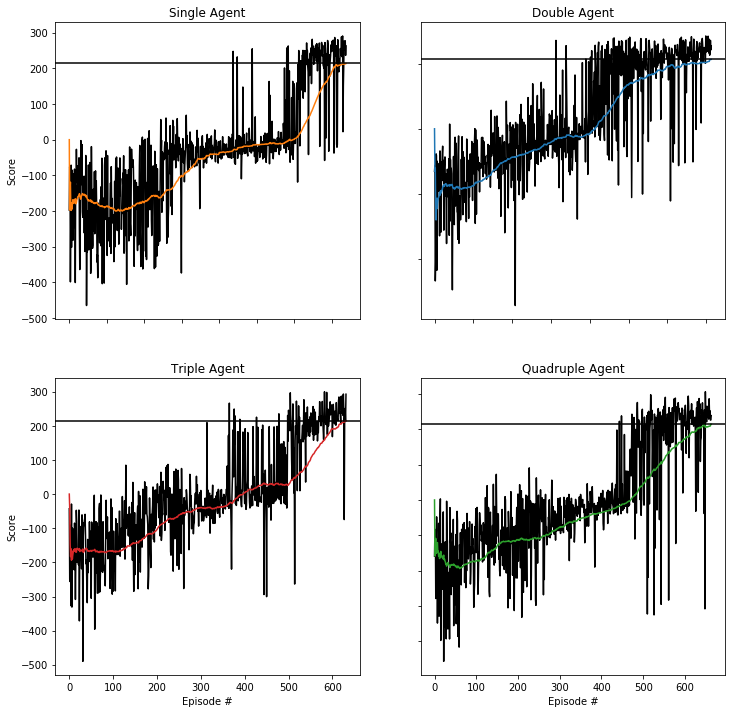

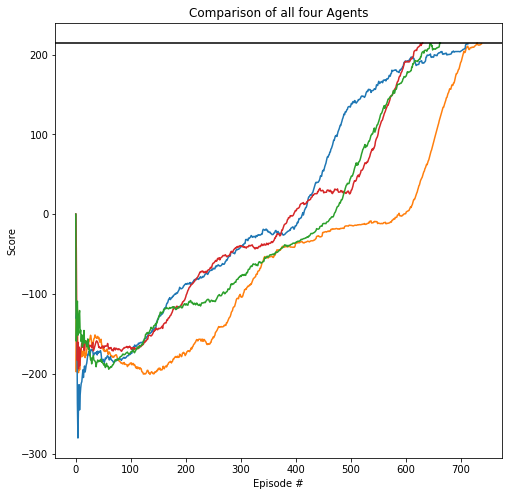

In [16]:
# Definition of helper function to calculate rolling mean
def runningMean(y, N):
    x = np.asarray(y)
    result = np.zeros(len(x))
    for i in range(1,len(x)):
        if i < int(N):
            result[i] = np.mean(x[0:i]) # Fill up first data points where index is smaller than window size
        else:
            result[i] = np.mean(x[i-N:i]) # Calculate rolling mean where index is larger than window size
    return result

f = open('scores_single.pckl', 'rb')
scores_single = pickle.load(f)
f.close()
f = open('scores_double.pckl', 'rb')
scores_double = pickle.load(f)
f.close()
f = open('scores_triple.pckl', 'rb')
scores_triple = pickle.load(f)
f.close()
f = open('scores_quadruple.pckl', 'rb')
scores_quadruple = pickle.load(f)
f.close()

# Calculate average scores of all four Agents with the same window=100 as used in the Q-learning algorithm
mean_single = runningMean(scores_single, 100)
mean_double = runningMean(scores_double, 100)
mean_triple = runningMean(scores_triple, 100)
mean_quadruple = runningMean(scores_quadruple, 100)

# Make four subplots and show results of each agent in one plot
fig, axs = plt.subplots(2, 2, figsize=(12,12))
axs[0, 0].plot(np.arange(len(scores_single)), scores_single, color="Black")
axs[0, 0].plot(np.arange(len(mean_single)), mean_single, 'tab:orange')
axs[0, 0].axhline(y=ENV_SOLVED, color="Black")
axs[0, 0].set_title('Single Agent')

axs[0, 1].plot(np.arange(len(scores_double)), scores_double, color="Black")
axs[0, 1].plot(np.arange(len(mean_double)), mean_double, 'tab:blue')
axs[0, 1].axhline(y=ENV_SOLVED, color="Black")
axs[0, 1].set_title('Double Agent')

axs[1, 0].plot(np.arange(len(scores_triple)), scores_triple, color="Black")
axs[1, 0].plot(np.arange(len(mean_triple)), mean_triple, 'tab:red')
axs[1, 0].axhline(y=ENV_SOLVED, color="Black")
axs[1, 0].set_title('Triple Agent')

axs[1, 1].plot(np.arange(len(scores_quadruple)), scores_quadruple, color="Black")
axs[1, 1].plot(np.arange(len(mean_quadruple)), mean_quadruple, 'tab:green')
axs[1, 1].axhline(y=ENV_SOLVED, color="Black")
axs[1, 1].set_title('Quadruple Agent')

for ax in axs.flat:
    ax.set(xlabel='Episode #', ylabel='Score')

for ax in axs.flat:
    ax.label_outer()

# Show averages of all fou agents in a single plot for comparison
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_single)), mean_single, 'tab:orange')
plt.plot(np.arange(len(mean_double)), mean_double, 'tab:blue')
plt.plot(np.arange(len(mean_triple)), mean_triple, 'tab:red')
plt.plot(np.arange(len(mean_quadruple)), mean_quadruple, 'tab:green')

plt.axhline(y=ENV_SOLVED, color="Black")

plt.title('Comparison of all four Agents')
plt.xlabel('Episode #')
plt.ylabel('Score')
plt.show()

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [17]:
env = gym.make('LunarLander-v2')
env.seed(0)

# Specify agent
agent = QuadrupleAgent()
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('quadruple_network_final.pth'))

for i in range(5):
    state = env.reset()
    for j in range(1000):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()